In [1]:
import pulp
import numpy as np

# 問題の設定
n_cities = 10  # 都市の数
n_salesmen = 5  # セールスマンの数
depot = 0  # デポ（出発点と終点）

forbidden_cities = {
    0: [2, 3],  # セールスマン1が行けない都市
    1: [4, 5],  # セールスマン2が行けない都市
    2: [6, 7],   # セールスマン3が行けない都市
    3: [],   # セールスマン4が行けない都市
    4: []  # セールスマン5が行けない都市
}
max_cost = {
    0: 400,  # セールスマン1の最大コスト
    1: 350,  # セールスマン2の最大コスト
    2: 400,  # セールスマン3の最大コスト
    3: 350,  # セールスマン4の最大コスト
    4: 450   # セールスマン5の最大コスト
}


# ランダムな都市の座標を生成
np.random.seed(41)
cities = np.random.rand(n_cities, 2) * 100

# 距離行列の計算
dist = np.sqrt(((cities[:, None, :] - cities[None, :, :]) ** 2).sum(axis=2))

# 問題の定義
prob = pulp.LpProblem("Multiple TSP", pulp.LpMinimize)

# 変数の定義
x = pulp.LpVariable.dicts("edge", 
                          ((i, j, k) for i in range(n_cities) for j in range(n_cities) if i != j 
                           for k in range(n_salesmen)),
                          cat='Binary')

# 目的関数
prob += pulp.lpSum(dist[i][j] * x[i, j, k] for i in range(n_cities) for j in range(n_cities) 
                   if i != j for k in range(n_salesmen))

# 制約条件
# 各都市は1回だけ訪問される
for j in range(1, n_cities):
    prob += pulp.lpSum(x[i, j, k] for i in range(n_cities) if i != j for k in range(n_salesmen)) == 1

# 各セールスマンはデポから出発し、デポに戻る
for k in range(n_salesmen):
    prob += pulp.lpSum(x[depot, j, k] for j in range(1, n_cities)) == 1
    prob += pulp.lpSum(x[i, depot, k] for i in range(1, n_cities)) == 1

# 各都市での入出の数は同じ
for k in range(n_salesmen):
    for j in range(n_cities):
        prob += pulp.lpSum(x[i, j, k] for i in range(n_cities) if i != j) == \
                pulp.lpSum(x[j, i, k] for i in range(n_cities) if i != j)

# 新しい制約: 各セールスマンが向かうことのできない都市の制約
for k, f_cities in forbidden_cities.items():
    for j in f_cities:
        if j != depot:  # デポは除外
            prob += pulp.lpSum(x[i, j, k] for i in range(n_cities) if i != j) == 0
            prob += pulp.lpSum(x[j, i, k] for i in range(n_cities) if i != j) == 0

# 新しい制約: 各セールスマンの最大コストの制約
for k, cost in max_cost.items():
    prob += pulp.lpSum(dist[i][j] * x[i, j, k] for i in range(n_cities) for j in range(n_cities) if i != j) <= cost

# サブツアー除去制約
u = pulp.LpVariable.dicts("u", ((i, k) for i in range(n_cities) for k in range(n_salesmen)), 
                          lowBound=0, upBound=n_cities-1, cat='Integer')

for i in range(1, n_cities):
    for j in range(1, n_cities):
        if i != j:
            for k in range(n_salesmen):
                prob += u[i, k] - u[j, k] + n_cities * x[i, j, k] <= n_cities - 1

# 問題を解く
prob.solve()

# 結果の表示
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Total distance: {pulp.value(prob.objective):.2f}")

# 各セールスマンのルートを表示
for k in range(n_salesmen):
    route = [depot]
    current = depot
    while True:
        next_city = [j for j in range(n_cities) if j != current and pulp.value(x[current, j, k]) == 1]
        if not next_city or next_city[0] == depot:
            break
        route.append(next_city[0])
        current = next_city[0]
    route.append(depot)
    print(f"Salesman {k+1} route: {route}")

/Users/yukiya/ws/caredx2024_rapid_prototyping/.venv/lib/python3.11/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yukiya/ws/caredx2024_rapid_prototyping/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/6h/jm2jl70d5sjcxnpkzl38w5nw0000gn/T/52e62e1c7fe241f9a625fa3f15d62903-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/6h/jm2jl70d5sjcxnpkzl38w5nw0000gn/T/52e62e1c7fe241f9a625fa3f15d62903-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 451 COLUMNS
At line 4925 RHS
At line 5372 BOUNDS
At line 5868 ENDATA
Problem MODEL has 446 rows, 495 columns and 3033 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 397.209 - 0.00 seconds
Cgl0002I 102 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 270 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 270 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 27

In [2]:
cities

array([[25.09236237,  4.60958207],
       [67.68162411,  4.34694856],
       [11.64237032, 60.38656889],
       [19.09306628, 66.85157173],
       [91.74478489, 41.87800869],
       [33.225985  , 28.30336352],
       [18.62822674, 31.71104705],
       [48.11686688,  6.95204678],
       [70.49825716, 31.4676934 ],
       [74.52823549, 39.82127959]])

Status: Optimal
Total distance: 448.42
Salesman 1 route: [0, 8, 9, 4, 1, 0]
Salesman 2 route: [0, 6, 0]
Salesman 3 route: [0, 2, 3, 0]
Salesman 4 route: [0, 5, 0]
Salesman 5 route: [0, 7, 0]


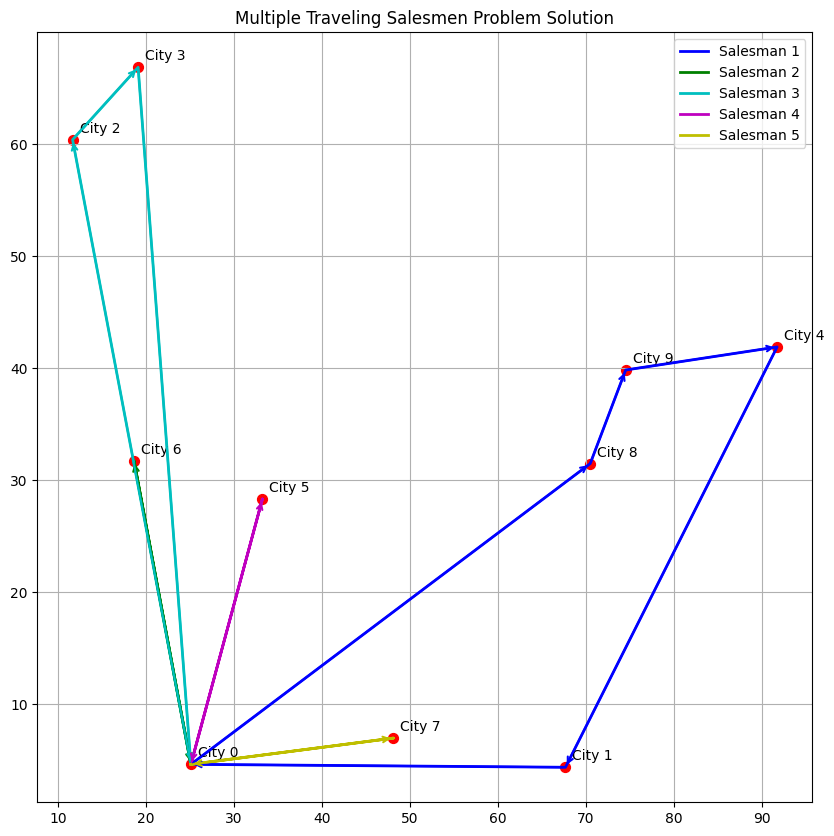

In [3]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

# 結果の表示（既存のコード）
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Total distance: {pulp.value(prob.objective):.2f}")

# 可視化のための準備
plt.figure(figsize=(10, 10))
plt.scatter(cities[:, 0], cities[:, 1], c='red', s=50)
for i, city in enumerate(cities):
    plt.annotate(f'City {i}', (city[0], city[1]), xytext=(5, 5), textcoords='offset points')

colors = ['b', 'g', 'c', 'm', 'y', 'k']  # セールスマンごとに異なる色を使用

# 各セールスマンのルートを表示と可視化
for k in range(n_salesmen):
    route = [depot]
    current = depot
    while True:
        next_city = [j for j in range(n_cities) if j != current and pulp.value(x[current, j, k]) == 1]
        if not next_city or next_city[0] == depot:
            break
        route.append(next_city[0])
        current = next_city[0]
    route.append(depot)
    print(f"Salesman {k+1} route: {route}")
    
    # ルートの可視化
    route_coords = cities[route]
    plt.plot(route_coords[:, 0], route_coords[:, 1], c=colors[k % len(colors)], linewidth=2, label=f'Salesman {k+1}')
    
    # 矢印の追加
    for i in range(len(route) - 1):
        plt.annotate('', xy=cities[route[i+1]], xytext=cities[route[i]],
                     arrowprops=dict(arrowstyle='->', color=colors[k % len(colors)], lw=1.5))

plt.title('Multiple Traveling Salesmen Problem Solution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def visualize_mtsp_solution(cities, routes, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(cities[:, 0], cities[:, 1], c='red', s=50)
    for i, city in enumerate(cities):
        plt.annotate(f'City {i}', (city[0], city[1]), xytext=(5, 5), textcoords='offset points')

    colors = ['b', 'g', 'c', 'm', 'y', 'k']

    for k, route in enumerate(routes):
        route_coords = cities[route]
        plt.plot(route_coords[:, 0], route_coords[:, 1], c=colors[k % len(colors)], linewidth=2, label=f'Salesman {k+1}')
        
        for i in range(len(route) - 1):
            plt.annotate('', xy=cities[route[i+1]], xytext=cities[route[i]],
                         arrowprops=dict(arrowstyle='->', color=colors[k % len(colors)], lw=1.5))

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def get_pulp_solution(prob, x, n_cities, n_salesmen, depot):
    routes = []
    for k in range(n_salesmen):
        route = [depot]
        current = depot
        while True:
            next_city = [j for j in range(n_cities) if j != current and pulp.value(x[current, j, k]) == 1]
            if not next_city or next_city[0] == depot:
                break
            route.append(next_city[0])
            current = next_city[0]
        route.append(depot)
        routes.append(route)
    return routes

def get_ortools_solution(manager, routing, solution):
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# PuLP solution visualization
pulp_routes = get_pulp_solution(prob, x, n_cities, n_salesmen, depot)
visualize_mtsp_solution(cities, pulp_routes, 'Multiple TSP Solution (PuLP)')

# OR-Tools solution
# Note: You need to implement the OR-Tools solver part here
# This is just a placeholder for the OR-Tools implementation
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(dist[from_node][to_node] * 100)  # Convert to integer

manager = pywrapcp.RoutingIndexManager(n_cities, n_salesmen, depot)
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add distance constraint
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Set first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

if solution:
    ortools_routes = get_ortools_solution(manager, routing, solution)
    visualize_mtsp_solution(cities, ortools_routes, 'Multiple TSP Solution (OR-Tools)')
else:
    print("No solution found with OR-Tools.")